# Taxi orders prediction

## Task

There are historical data on taxi orders at airports. In order to attract more drivers during the peak period, we need to forecast the number of taxi orders for the next hour.  
The value of the RMSE metric on the test sample should not be greater than 48.

In [1]:
!pip install lightgbm

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import lightgbm as lgb
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

In [3]:
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Columns:
- datetime – date and time of recording
- num_orders – number of taxi orders

## Data preprocessing

We'll check for missing values and duplicates just in case.

In [5]:
data.duplicated().sum()

0

In [6]:
len(data['datetime'].unique())

26496

In [7]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Let's put time as an index.

In [8]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Resampling

Let's calculate the sum of orders for each hour.

In [9]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Exploratory data analysis

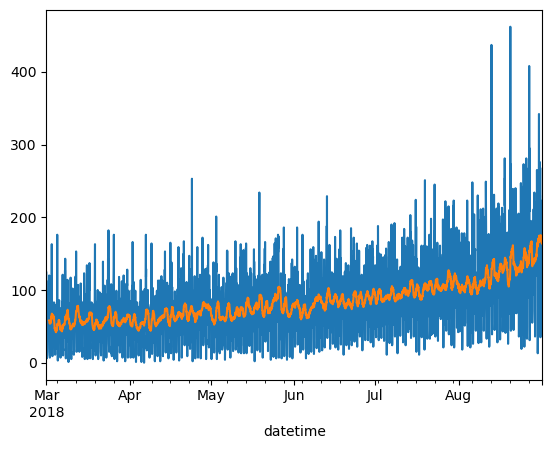

In [10]:
data['num_orders'].plot()
data['num_orders'].rolling(25).mean().plot() # over the past 24 hours
plt.show()

### By day

Let's look at the mean value for each day.

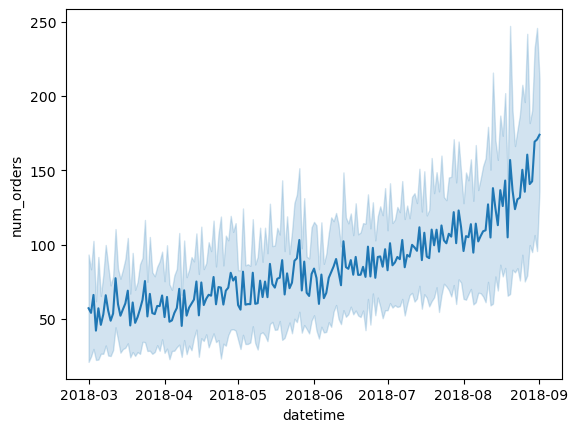

In [11]:
sb.lineplot(x=data.index.round('d'), y=data['num_orders'], estimator='mean', errorbar='sd')
plt.show()

The mean is clearly rising. It would be interesting to check the months for seasonality, but unfortunately there is no data for this.

### By week

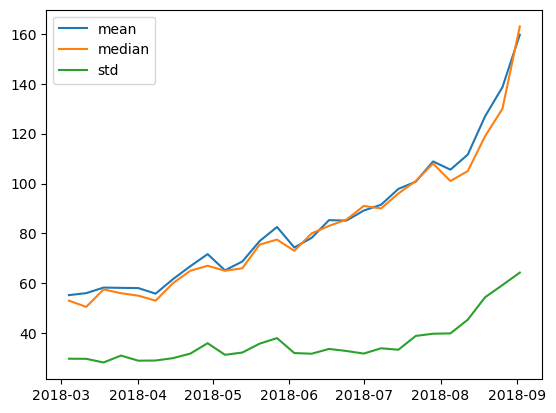

In [12]:
plt.plot(data['num_orders'].resample('1W').mean(), label='mean')
plt.plot(data['num_orders'].resample('1W').median(), label='median')
plt.plot(data['num_orders'].resample('1W').std(), label='std')
plt.legend()
plt.show()

### By month

In [13]:
stat_by_month = data['num_orders'].resample('1M').agg(['count', 'mean', 'sum'])
stat_by_month.index = stat_by_month.index.month
stat_by_month

,count,mean,sum
datetime,,,
3,744,57.483871,42768
4,720,63.804167,45939
5,744,73.682796,54820
6,720,83.202778,59906
7,744,100.006720,74405
8,744,127.651882,94973


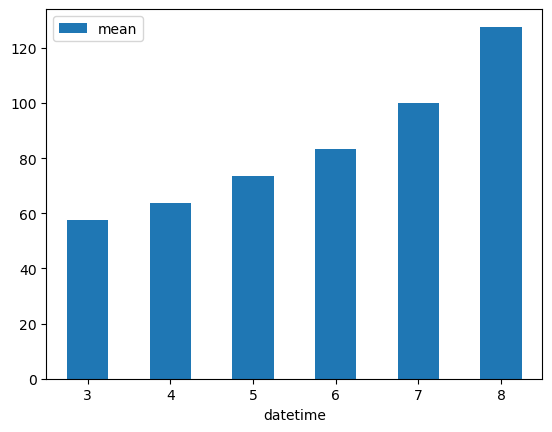

In [14]:
stat_by_month['mean'].plot(kind='bar')
plt.xticks(rotation=0)
plt.legend()
plt.show()

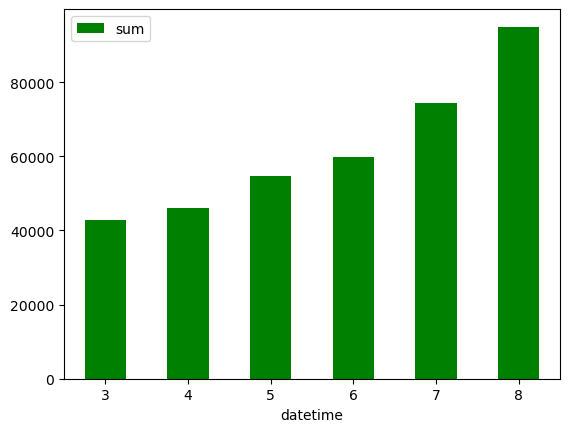

In [15]:
stat_by_month['sum'].plot(kind='bar', color='green')
plt.xticks(rotation=0)
plt.legend()
plt.show()

I think this feature comes in handy when training.

### Trends and seasonality

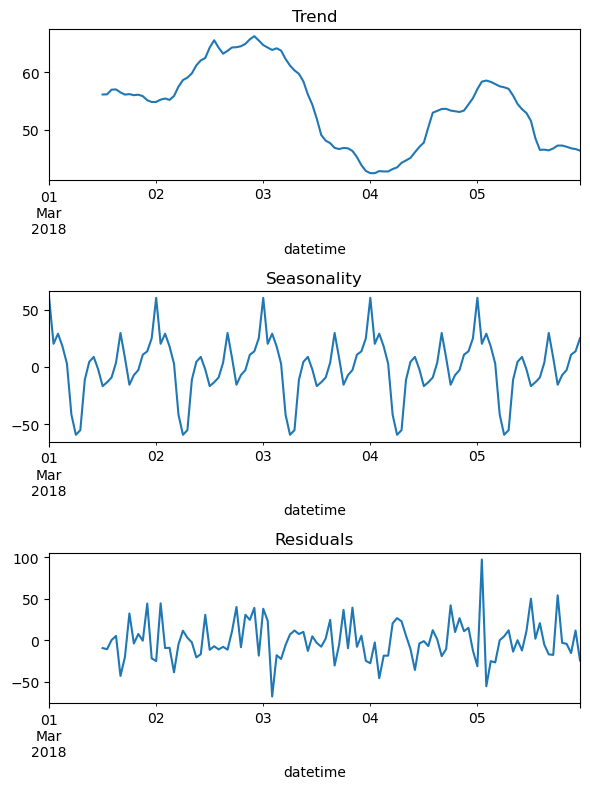

In [16]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Let's look at the seasonality within the week.

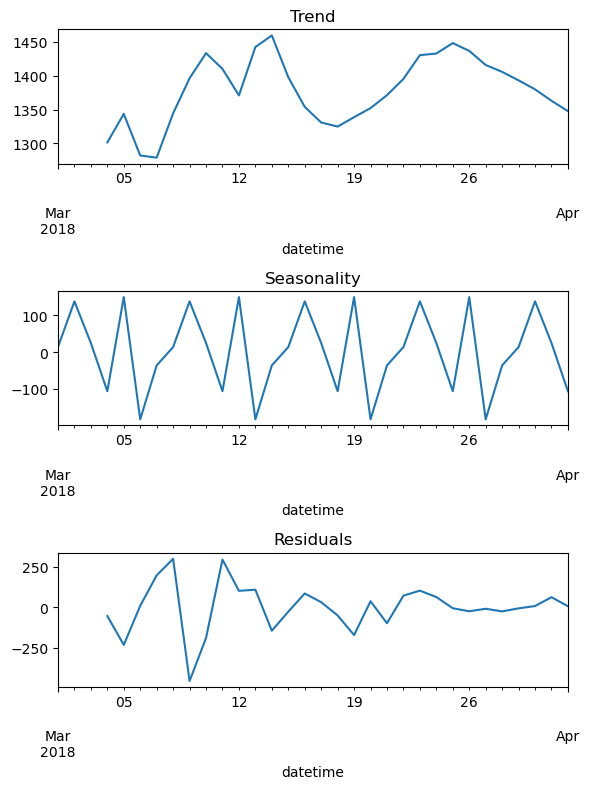

In [17]:
decomposed_by_day = seasonal_decompose(data.resample('1D').sum()['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_by_day.trend['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_by_day.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_by_day.resid['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The expected seasonality by day of the week is found.

### By weekday

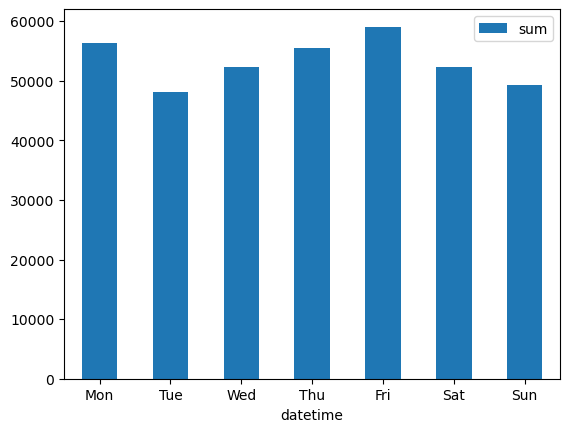

In [18]:
data.groupby(data.index.weekday)['num_orders'].agg(['sum']).plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()

The weekend can probably still be explained, but Tuesday's dip is incomprehensible.

### By hour

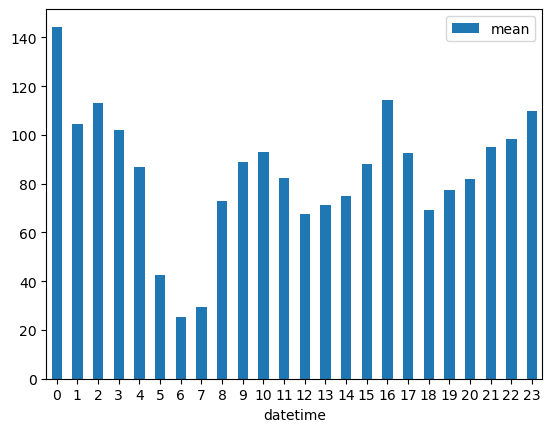

In [19]:
data.groupby(data.index.hour)['num_orders'].agg(['mean']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

That's a significant difference. There aren't many flights in the early morning.

### By day of the month

Let's look at the number of orders by day within months.

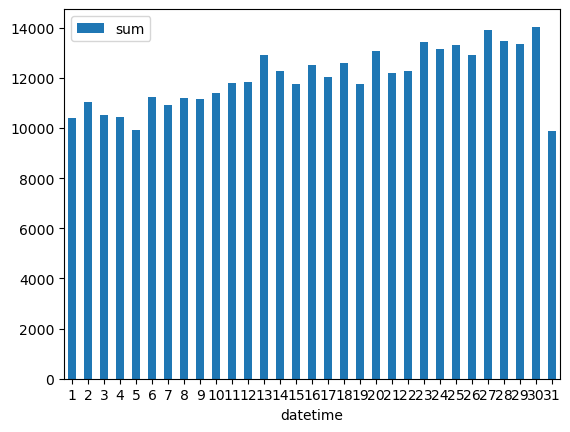

In [20]:
data.groupby(data.index.day)['num_orders'].agg(['sum']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

The drop for the 31st day may be due to the fact that not all months have 31 days.

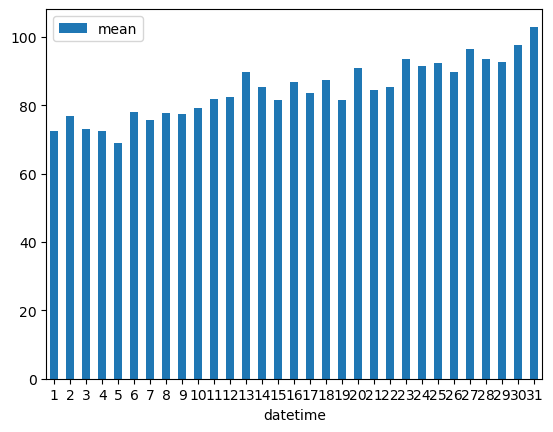

In [21]:
data.groupby(data.index.day)['num_orders'].agg(['mean']).plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Well, yes. Nevertheless, a slight increase is noticeable, not really explainable yet.

Let's look at April. There may not have been enough data for March.

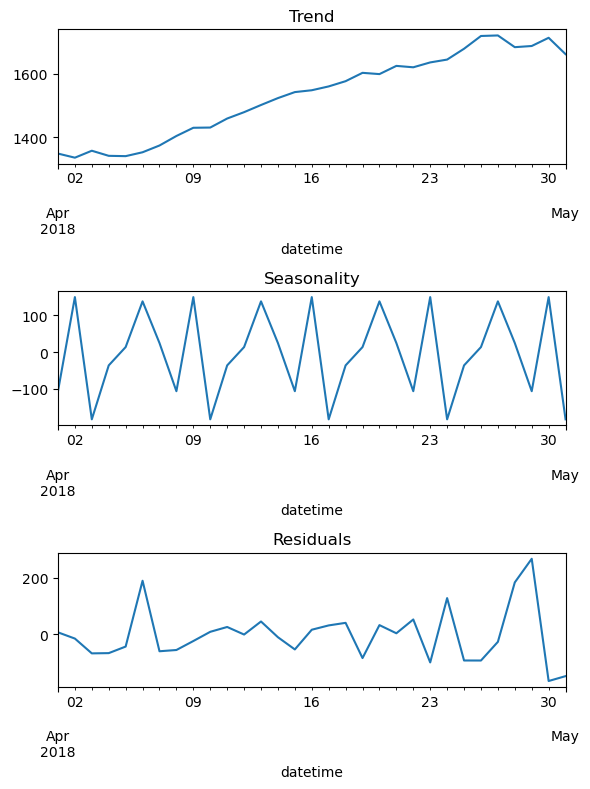

In [22]:
decomposed_by_day = seasonal_decompose(data.resample('1D').sum()['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_by_day.trend['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_by_day.seasonal['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_by_day.resid['2018-04-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In general, the trend is increasing.  
From here we can also see that seasonal fluctuations in the number of orders are independent of the trend.

### Time series differences

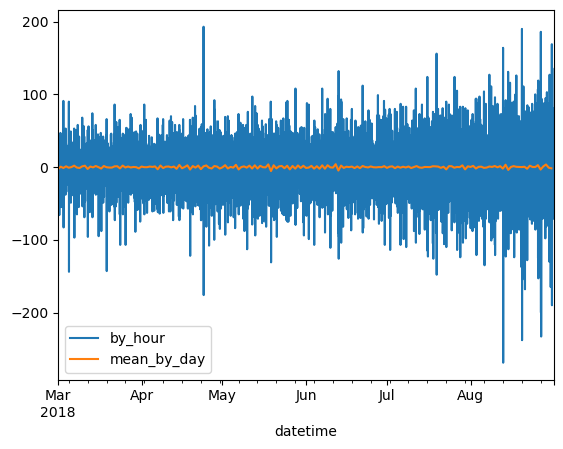

In [23]:
(data['num_orders'] - data['num_orders'].shift(1)).plot(
    label='by_hour')
(data['num_orders'] - data['num_orders'].shift(1)).resample('1D').mean().plot(
    label='mean_by_day')
plt.legend()
plt.show()

There is no difference from the previous hour.

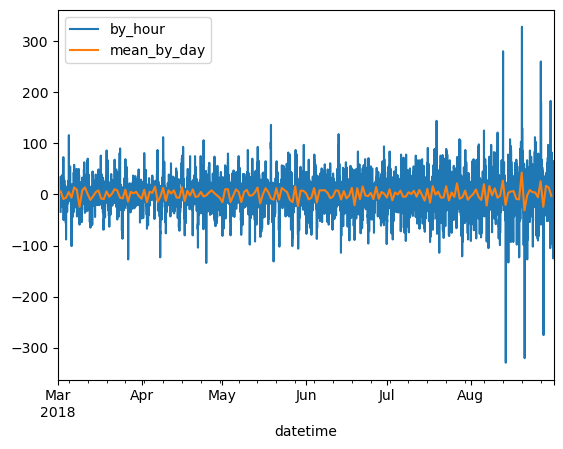

In [24]:
(data['num_orders'] - data['num_orders'].shift(24)).plot(
    label='by_hour')
(data['num_orders'] - data['num_orders'].shift(24)).resample('1D').mean().plot(
    label='mean_by_day')
plt.legend()
plt.show()

The shift by day is more volatile, but still close to zero.

Let's check stationarity by the Dickey-Fuller test.

In [25]:
result = adfuller(data)
print('Statistic:', round(result[0], 3))
print('Critical_values:')
for key, value in result[4].items():
    print(key, ':', round(value, 3))
print('p-value:', result[1])
if result[0] < result[4]['5%']:
    print('Rejecting H0: data is stationary (5% confidence)')
else:
    print('Failed to rejct H0: data is not stationary (5% confidence)')

Statistic: -3.069
Critical_values:
1% : -3.432
5% : -2.862
10% : -2.567
p-value: 0.028940051402613316
Rejecting H0: data is stationary (5% confidence)


That is, with 5% accuracy the series is stationary.

## Samples

In [26]:
data = pd.DataFrame(data['num_orders'])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [27]:
data_train, data_test = train_test_split(data, shuffle=False, test_size=0.1)

Let's separate the following attributes for training:
- Day of the week (there is seasonality)
- Hour (there is daily seasonality)
- Shift in the number of orders (as an autoregressive parameter)
- Moving average (as an analog of trend)

In [28]:
def datasets(data, max_lag, rolling_mean_size, convert=False):
    # features
    data = pd.DataFrame(data)
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
    
    for i in range(max_lag):
        data[f'lag_{i+1}'] = data.iloc[:,0].shift(i+1)
        
    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    
    # samples
    features = data.drop('num_orders', axis=1)
    target = data['num_orders']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, shuffle=False, test_size=0.2)
    
    features_train = features_train.copy()
    features_valid = features_valid.copy()
    
    # transformation
    if convert:
        cat_features = ['hour', 'day_of_week']
        numeric_features = features_train.columns[~features_train.columns.isin(cat_features)]

        # scaling
        scaler = StandardScaler()
        scaler.fit(features_train.loc[:, numeric_features])
        
        features_train.loc[:, numeric_features] = scaler.transform(
            features_train.loc[:, numeric_features])
        features_valid.loc[:, numeric_features] = scaler.transform(
            features_valid.loc[:, numeric_features])
        
        # one-hot encoding
        features_train = pd.get_dummies(features_train, drop_first=True, 
                                        columns=cat_features)
        features_valid = pd.get_dummies(features_valid, drop_first=True, 
                                       columns=cat_features)
        common_columns = set(features_train.columns) & set(features_valid.columns)
        features_train = features_train.loc[:, list(common_columns)]
        features_valid = features_valid.loc[:, list(common_columns)]
        
    return features_train, features_valid, target_train, target_valid

Example of how to use the function:

In [29]:
features_train, features_valid, target_train, target_valid = datasets(
    data_train['num_orders'], 3, 5)
print(data['num_orders'].shape)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
features_train.head()

(4416,)
(3175, 6)
(794, 6)
(3175,)
(794,)


,hour,day_of_week,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,
2018-03-01 05:00:00,5,3,43.0,66.0,71.0,77.8
2018-03-01 06:00:00,6,3,6.0,43.0,66.0,54.2
2018-03-01 07:00:00,7,3,12.0,6.0,43.0,39.6
2018-03-01 08:00:00,8,3,15.0,12.0,6.0,28.4
2018-03-01 09:00:00,9,3,34.0,15.0,12.0,22.0


In [30]:
features_train, features_valid, target_train, target_valid = datasets(
    data_train['num_orders'], 3, 5, convert=True)
print(data['num_orders'].shape)
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
features_train.head()

(4416,)
(3175, 33)
(794, 33)
(3175,)
(794,)


,hour_13,hour_2,day_of_week_1,hour_21,day_of_week_2,hour_20,rolling_mean,lag_3,lag_1,hour_17,...,hour_1,hour_10,lag_2,hour_14,hour_19,hour_12,day_of_week_4,hour_3,hour_6,day_of_week_3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 05:00:00,0,0,0,0,0,0,0.275021,-0.006162,-0.824197,0,...,0,0,-0.152448,0,0,0,0,0,0,1
2018-03-01 06:00:00,0,0,0,0,0,0,-0.712060,-0.152166,-1.904347,0,...,0,0,-0.823970,0,0,0,0,0,1,1
2018-03-01 07:00:00,0,0,0,0,0,0,-1.322712,-0.823785,-1.729188,0,...,0,0,-1.904245,0,0,0,0,0,0,1
2018-03-01 08:00:00,0,0,0,0,0,0,-1.791158,-1.904216,-1.641608,0,...,0,0,-1.729065,0,0,0,0,0,0,1
2018-03-01 09:00:00,0,0,0,0,0,0,-2.058841,-1.729011,-1.086936,0,...,0,0,-1.641475,0,0,0,0,0,0,1


In [31]:
print(sorted(features_train.columns))

['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean']


## Training

Let's try linear regression, ElasticNet (as a compromise between Lasso and Ridge regressions) and LightGBM.

In [32]:
# function for hyperparameter selection
def get_shift_and_size(data, model, convert=False):
    best_train_rmse = 1000
    best_test_rmse = 1000
    best_model = None
    best_shift = 0
    best_mean_size = 0
    for shift in [1, 12, 24]:
        for mean_size in [1, 12, 24, 48]:

            features_train, features_test, target_train, target_test = datasets(
                data, shift, mean_size, convert=convert)

            model = model

            model.fit(features_train, target_train)
            predictions_train = model.predict(features_train)
            predictions_test = model.predict(features_test)

            if mse(target_test, predictions_test)**0.5 < best_test_rmse:
                best_model = model
                best_shift = shift
                best_mean_size = mean_size
                best_train_rmse = mse(target_train, predictions_train)**0.5
                best_test_rmse = mse(target_test, predictions_test)**0.5

    # if best_model.__class__.__name__ != 'LinearRegression':
    try:
        print(best_model.best_params_)
    except:
        pass
    print('RMSE on the training sample:', best_train_rmse)
    print('RMSE on the test sample:', best_test_rmse)
    print('Best shift:', best_shift)
    print('Best window for moving average:', best_mean_size)
    
    return best_shift, best_mean_size

### Linear regression

In [33]:
get_shift_and_size(data_train['num_orders'], LinearRegression())

RMSE on the training sample: 23.81484449120641
RMSE on the test sample: 33.1774665513628
Best shift: 24
Best window for moving average: 48


(24, 48)

In [34]:
get_shift_and_size(data_train['num_orders'], LinearRegression(), convert=True)

RMSE on the training sample: 20.800634354966395
RMSE on the test sample: 30.376202604847247
Best shift: 24
Best window for moving average: 48


(24, 48)

It seems to work better with scaling.

### ElasticNet

In [35]:
get_shift_and_size(data_train['num_orders'], ElasticNet(tol=0.01))

RMSE on the training sample: 23.81821919955361
RMSE on the test sample: 33.1906677075976
Best shift: 24
Best window for moving average: 48


(24, 48)

In [36]:
get_shift_and_size(data_train['num_orders'], ElasticNet(tol=0.01), convert=True)

RMSE on the training sample: 24.846163987838853
RMSE on the test sample: 34.39878374979448
Best shift: 24
Best window for moving average: 48


(24, 48)

Here, on the contrary, the scaling made it worse.

### LightGBM

In the case of time series in cross-validation, the samples have to be ordered.

In [37]:
%%time
params_grid = {'learning_rate': [0.05, 0.1], 
               'n_estimators': [100, 300], 
               'colsample_bytree': [0.7, 1.0], 
               'verbose':[-1]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, cv=TimeSeriesSplit(n_splits=3), 
                     scoring='neg_root_mean_squared_error')

get_shift_and_size(data_train['num_orders'], model)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100, 'verbose': -1}
RMSE on the training sample: 15.006323350523274
RMSE on the test sample: 30.562846978998806
Best shift: 12
Best window for moving average: 48
CPU times: user 3min 14s, sys: 5.72 s, total: 3min 19s
Wall time: 49.9 s


(12, 48)

In [38]:
%%time
params_grid = {'learning_rate': [0.05, 0.1], 
               'n_estimators': [100, 300], 
               'colsample_bytree': [0.7, 1.0], 
               'verbose':[-1]}

model = GridSearchCV(estimator=lgb.LGBMRegressor(objective='regression', random_state=57), 
                     param_grid=params_grid, cv=TimeSeriesSplit(n_splits=3), 
                     scoring='neg_root_mean_squared_error')

get_shift_and_size(data_train['num_orders'], model, convert=True)

{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'n_estimators': 100, 'verbose': -1}
RMSE on the training sample: 14.013901243194743
RMSE on the test sample: 32.553726437104054
Best shift: 24
Best window for moving average: 1
CPU times: user 4min 15s, sys: 9.71 s, total: 4min 25s
Wall time: 1min 6s


(24, 1)

## Results

We get the following table:
<a id='table'>
    
|Model|Optimal shift|Optimal window of mean|RMSE|
|-|-|-|-|
|LinearRegression|24|48|30.38|
|ElasticNet|24|48|33.19|
|LightGBM|12|48|30.56|

</a>

Thus, a linear regression is sent for testing.

## Sanity check

In [39]:
# by medians
pred_median = np.ones(data_test['num_orders'].shape) * data_train['num_orders'].median()
print("RMSE:", mse(data_test['num_orders'], pred_median)**0.5)

RMSE: 87.15277582981295


In [40]:
# by previous value
pred_previous = data_test['num_orders'].shift(
    fill_value=float(data_train['num_orders'].iloc[-1]))
print("RMSE:", mse(data_test['num_orders'], pred_previous)**0.5)

RMSE: 58.856486242815066


The second cutoff is noticeably stricter.

## Testing

We will train on both the training and validation samples.

In [41]:
data_train.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [42]:
# features
data_train = data_train.copy()
data_test = data_test.copy()
for dataset in [data_train, data_test]:
    dataset['month'] = dataset.index.month
    dataset['day'] = dataset.index.day
    dataset['hour'] = dataset.index.hour
    dataset['day_of_week'] = dataset.index.dayofweek
    for i in range(20):
        dataset[f'lag_{i+1}'] = dataset['num_orders'].shift(i+1)
    dataset['rolling_mean'] = dataset['num_orders'].shift().rolling(48).mean()
    dataset.dropna(inplace=True)

In [43]:
# samples
features_train = data_train.drop('num_orders', axis=1)
features_test = data_test.drop('num_orders', axis=1)
target_train = data_train['num_orders']
target_test = data_test['num_orders']

In [44]:
cat_features = ['month', 'day', 'hour', 'day_of_week']
numeric_features = features_train.columns[~features_train.columns.isin(cat_features)]

# scaling
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric_features])
        
features_train.loc[:, numeric_features] = scaler.transform(
            features_train.loc[:, numeric_features])
features_test.loc[:, numeric_features] = scaler.transform(
            features_test.loc[:, numeric_features])
        
# one-hot encoding
features_train = pd.get_dummies(features_train, drop_first=True, 
                                        columns=cat_features)
features_test = pd.get_dummies(features_test, drop_first=True, 
                                       columns=cat_features)
common_columns = set(features_train.columns) & set(features_test.columns)
features_train = features_train.loc[:, list(common_columns)]
features_test = features_test.loc[:, list(common_columns)]

In [45]:
features_train.head()

,day_24,day_30,hour_13,day_20,hour_2,day_of_week_1,day_29,hour_21,hour_20,rolling_mean,...,lag_6,hour_12,day_17,day_25,day_of_week_4,day_22,hour_3,hour_6,lag_20,day_of_week_3
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,0,0,0,0,0,0,0,0,0,-1.005689,...,0.272587,0,0,0,0,0,0,0,-1.526223,0
2018-03-03 01:00:00,0,0,0,0,0,0,0,0,0,-0.961063,...,-0.762075,0,0,0,0,0,0,0,-1.762654,0
2018-03-03 02:00:00,0,0,0,0,1,0,0,0,0,-0.934746,...,0.376053,0,0,0,0,0,0,0,-1.762654,0
2018-03-03 03:00:00,0,0,0,0,0,0,0,0,0,-0.987381,...,0.582985,0,0,0,0,0,1,0,-1.867735,0
2018-03-03 04:00:00,0,0,0,0,0,0,0,0,0,-0.989669,...,1.048583,0,0,0,0,0,0,0,-0.843200,0


In [46]:
target_test

datetime
2018-08-15 14:00:00    107
2018-08-15 15:00:00    103
2018-08-15 16:00:00    219
2018-08-15 17:00:00    165
2018-08-15 18:00:00     96
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 394, dtype: int64

In [47]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('RMSE:', mse(target_test, predictions_test)**0.5)

RMSE: 42.52760248760594


RMSE <= 48, so the test is passed.

## Conclusions

1. Statistical patterns
- The data covers the period from March 1 to August 31, 2018.
- The number of orders is increasing throughout the time period.
- There is a seasonality by hours during the day. The least number of orders is at 5, 6 and 7 am.
- There is also a seasonality by week. There are fewer orders on Tuesdays and weekends.
- The data is distributed stationary.

2. Model training
- Linear regression, ElasticNet, and LightGBM were tried.
- The models were trained on days of the week, hours, moving average and autoregressive shift.
- The best RMSE was obtained with a shift of 24 hours and a moving window of 48 hours.
- All models passed the sanity check (RMSE < 58.86).
- Linear regression performed the best, but the [difference](#table) is small.
- In testing, the model showed RMSE = 42.53